## Introduction

Disclaimer: This notebook is was made for coursework.

The dataset for this notebook was taken from [Kaggle](https://www.kaggle.com/competitions/nlp-getting-started). Nowadays because of the proliferation of social media, more news can be received almost immediately and in vast volumes. Twitter is a prime example of this. Tweets are short texts that anyone on the platform can send out to the public. In which case, it is very useful in reporting disasters to the community and world. The dataset comprises of 7000+ tweets for analysis. The goal of this notebook is to try to create a machine learning algorithm that can predict whether a tweet is announcing a disaster or not. 

A NLP machine learning algorithm that uses similarity calculations may be a possible method of prediction but for this notebook we are going to try to use a deep learning neural network, more specifically, using a Recurrent Neural Network (RNN) to differentiate the tweets.

Recurrent Neural Networks are deep learning neural networks that differ from the general forward propagation types. RNNs can take inputs from the node before it but also can send the signal out to form a cycle back to itself. The nodes within these networks can have long term memories. In short, they can remember some things which can be useful for sequential and time series data. In the case of this notebook, RNNs are useful in that they can remember prior word patterns which can help differentiate the disaster tweets.

With that said, let's get started.

## Exploratory Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow and model development
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# NLP (words into features)
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# for model training
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We see that the training dataset provided has 5 columns, [id, keyword, location, text, target].
- id: the tweet id; the id skip some numbers because those ids are used in the test set instead.
- keyword: as the name suggests, the keyword within the tweet, although it can be blank as seen above.
- location: the location the tweet was sent from - can also be null
- text: the text of the tweet that we are going to use as our features in the model
- target: the labels; 0 = non-disaster and 1 = disaster.

We see that the test set below is similar to the training set minus the presence of the target column which is what we are trying to get from our model.

In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [6]:
print('Shape:', train.shape, '\n')
train.info()

Shape: (7613, 5) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


We see that there are a total of 7613 sample tweets in our training set. Notice that the id, text, and target columns both equal the total sample tweets so there are no null values in those columns. We confirm that there are null values in the keyword and location columns. We can leave them as is because we won't be using those columns for our model development. The only columns of interest are text and target and they both don't have nulls/missing values.

Now let's look at a sample text. We see that there are punctuations in the text and if we look back to the sample showings of the datasets above, we notice there are numbers and hashtags in the tweets as well.

In [7]:
train.text[1]

'Forest fire near La Ronge Sask. Canada'

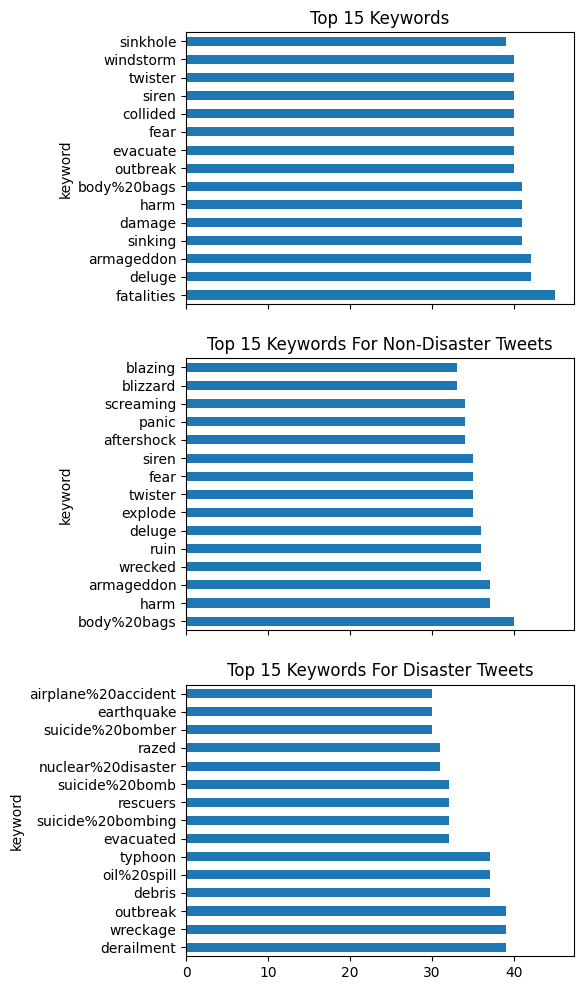

In [8]:
# plotting top 15 keywords
fig, ax = plt.subplots(3, 1, figsize=(5, 12), sharex=True)

train.keyword.value_counts()[:15].plot(kind='barh', title='Top 15 Keywords', ax=ax[0])
train[train.target == 0].keyword.value_counts()[:15].plot(kind='barh', title='Top 15 Keywords For Non-Disaster Tweets',
                                                         ax=ax[1])
train[train.target == 1].keyword.value_counts()[:15].plot(kind='barh', title='Top 15 Keywords For Disaster Tweets', 
                                                          ax=ax[2])

plt.show()

Examining the keywords column and plotting the word count we see that in general most tweets have words like 'fatalities', 'deluge' and 'armageddon'. The rest of the keywords seem to have a negative connotation overall. 

Looking at the keywords for non-disaster tweets, we see words like 'body bags', 'harm', 'armageddon'. These words give a sense of danger but does not seem to be anything conclusive. Looking at the disaster tweet keywords, we see specific words related to incidents such as 'derailment', 'suicide bombing', and 'oil spill'.

In other words, disaster tweets seem to be about more specific incidents whereas the non-disaster tweets may just be talking about thing which a sense of danger.

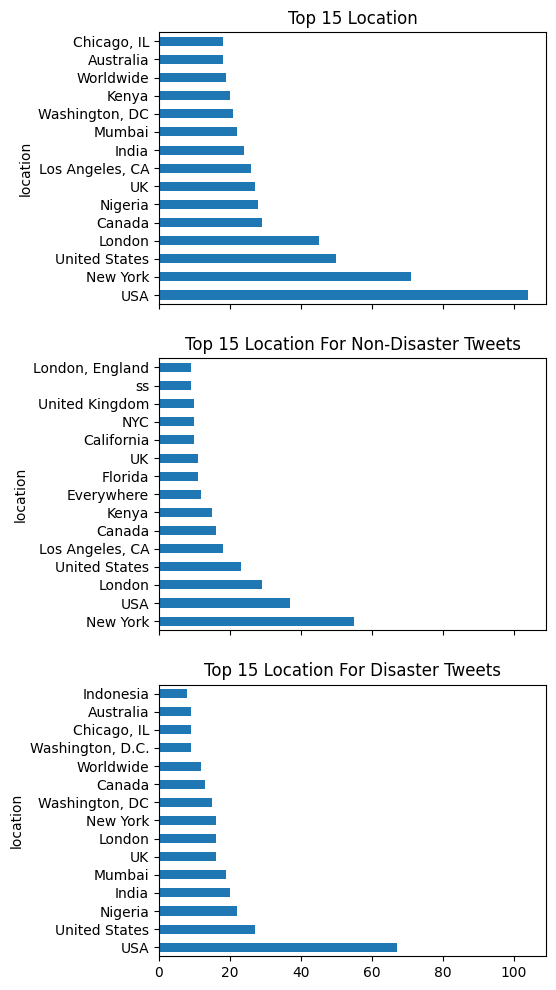

In [9]:
# plotting top 15 locations
fig, ax = plt.subplots(3, 1, figsize=(5, 12), sharex=True)

train.location.value_counts()[:15].plot(kind='barh', title='Top 15 Location', ax=ax[0])
train[train.target == 0].location.value_counts()[:15].plot(kind='barh', title='Top 15 Location For Non-Disaster Tweets', ax=ax[1])
train[train.target == 1].location.value_counts()[:15].plot(kind='barh', title='Top 15 Location For Disaster Tweets', ax=ax[2])
plt.show()

Looking at the locations we see that most tweets come from the US in general. New York has the most tweets for non-disaster tweets. These results can be a due to just sampling mostly from American tweets but it may also be that Twitter is very prominent in the US. New York is also a commercial hub in the country thus it is plausible to see that it has the most non-disaster related tweets. They could be talking about so many other things there. 

target
0    4342
1    3271
Name: count, dtype: int64


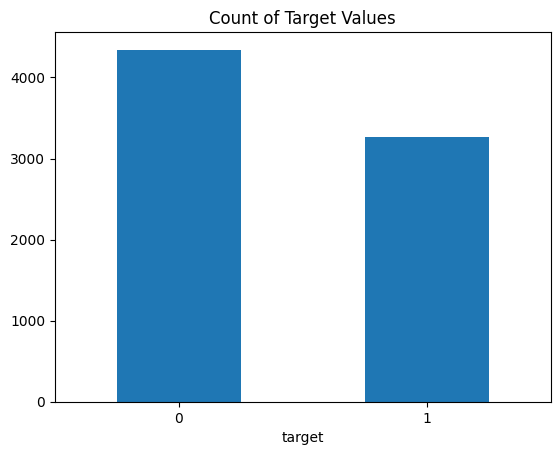

In [10]:
print(train.target.value_counts())

train.target.value_counts().plot(kind='bar', title='Count of Target Values')

# xticks were rotated from the above code so this is to 'unrotate' it
plt.xticks(rotation=0)
plt.show()

There is no huge discrepancy between the number of disaster tweets compared to non-disaster tweets so we are going to move forward as is. The difference is only around 1000.

In [11]:
train[train.text.duplicated() == True]

,id,keyword,location,text,target
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
119,172,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
164,238,airplane%20accident,NaN,Experts in France begin examining airplane deb...,1
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
...,...,...,...,...,...
7600,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


Here we check for duplicated text and we see there are indeed some duplicates such as the below example. We also see that some tweets may also have links in them. 

For how we are going to deal with duplicates, normally I would delete them because they are redundant however if you if look a little further down, we see another duplicate example of 'To fight bioterrorism sir'. Looking at the target label for those duplicates and they are not the same like the previous example - some of are considered disasters whereas others not. I don't want to manually decide what each tweet target will be so I am going to leave the duplicates as is. 

In [12]:
train.text[48]

'Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw'

In [13]:
train[train.text == train.text[48]]

,id,keyword,location,text,target
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0


In [14]:
train[train.text == train.text[624]]

,id,keyword,location,text,target
610,881,bioterrorism,NaN,To fight bioterrorism sir.,1
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
630,907,bioterrorism,NaN,To fight bioterrorism sir.,1
634,916,bioterrorism,NaN,To fight bioterrorism sir.,0


I was curious about what the keyword 'body bag' was for so I looked at some examples to see whether they were actually tweets about body bags - the stuff you would see in crime or horror scenes.

In [15]:
train[train.keyword == 'body%20bags'].head()

,id,keyword,location,text,target
1018,1479,body%20bags,"Austin, Texas",@FoxNews @JenGriffinFNC When you call to repor...,1
1019,1480,body%20bags,Oklahoma City,Micom 2015 Summer Contrast Candy Color Bowknot...,0
1020,1482,body%20bags,CA,HOBO Hobo Vintage Shira Convertible BÛ_ $238....,0
1021,1483,body%20bags,NaN,Child Shoulder Bags PVC Shoulder Book Bag Cart...,0
1022,1484,body%20bags,United Kingdom,Womens Buckle Casual Stylish Shoulder Handbags...,0


In [16]:
print('When target = 1: \n', train.text[1018])
print()
print('When target = 0: \n', train.text[1019])

When target = 1: 
 @FoxNews @JenGriffinFNC When you call to report dangerous activity tell em to have body bags on arrival.

When target = 0: 
 Micom 2015 Summer Contrast Candy Color Bowknot Cross Body Tote Shoulder Bags for Womengirls with Micom Zip Po http://t.co/sQMTKKJiMJ


And as some might have guess they weren't always about 'body bags' - the type seen in horror or crime shows. Instead there were some tweets that were just about bags around the body, stuff like purses or totes. This suggests that some keywords may be misleading. 

But that should be it for the data analysis. We are going to move forward focusing primarily on the text and target columns.

## Preprocessing

First we need to prepare the data for our model. We are going to remove the links because they are not helpful in our context. We are also going to remove special characters and punctuations, remove stop words and lemmatize them. Lemmatization means that we are changing the words to their root word. For example, 'ran' would become 'run', things like that to keep the training process as simple as we can.

In [17]:
def text_preprocess(df, text_col):
    
    lemmatizer = WordNetLemmatizer()
    corpus = []

    text = list(df[text_col])
    for i in range(len(text)):
        # remove links
        r = re.sub(r'http\S+', "", text[i])
        # remove special characters and punctuation
        r = re.sub('[^a-zA-Z]', ' ', r)
        r = r.split()
        # lemmatize the words not considered stopgaps
        r = [lemmatizer.lemmatize(word) for word in r if word not in stopwords.words('english')]
        r = ' '.join(r)

        corpus.append(r)
    
    df[text_col] = corpus
    return

In [18]:
text_preprocess(train, 'text')

In [19]:
print(train.text[48])
print()
print(train.text[1])

Check nsfw

Forest fire near La Ronge Sask Canada


Link removed, hashtag removes, punctuation removed. That's good.

Next we are going to tokenize the words, meaning we are going to separate the words from the sentence and put them into a list. This way we can look at each word one by one.

In [20]:
def text_tokenize(df, text_col):
    df['tokenized'] = df.apply(lambda x: word_tokenize(x[text_col]), axis=1)
    return

In [21]:
text_tokenize(train, 'text')
train['num_words'] = train['tokenized'].apply(lambda x: len(x))

In [22]:
train.head()

,id,keyword,location,text,target,tokenized,num_words
0,1,NaN,NaN,Our Deeds Reason earthquake May ALLAH Forgive u,1,"[Our, Deeds, Reason, earthquake, May, ALLAH, F...",8
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,"[Forest, fire, near, La, Ronge, Sask, Canada]",7
2,5,NaN,NaN,All resident asked shelter place notified offi...,1,"[All, resident, asked, shelter, place, notifie...",13
3,6,NaN,NaN,people receive wildfire evacuation order Calif...,1,"[people, receive, wildfire, evacuation, order,...",6
4,7,NaN,NaN,Just got sent photo Ruby Alaska smoke wildfire...,1,"[Just, got, sent, photo, Ruby, Alaska, smoke, ...",10


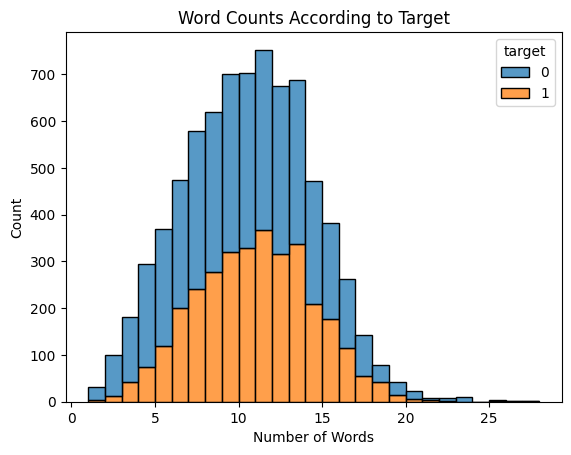

In [23]:
sns.histplot(data=train, x='num_words', hue='target', multiple='stack', binwidth=1)
plt.title('Word Counts According to Target')
plt.xlabel('Number of Words')
plt.show()

Here we see that the number of tokenized words in each tweet averages around 12 words. The distribution for both labels look to be about the same. The maximum number of is around 27 words in our training set.

In [24]:
unique = set()

for lst in train.tokenized:
    current = set(lst)
    for word in current:
        unique.add(word)

print(f'There are {len(unique)} unique words present in the training set.')

There are 19437 unique words present in the training set.


For the purpose of training a RNN with words, we have to change them into integers. This means that each word would equal a number. For example, 'fire' would equate to 4, and 'body' can equate something like 354. This helps the model train by remembering the number sequence to predict the label.

In [25]:
# tokenizing the words and changing into integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.text.values) # fit
train['tokenizer'] = tokenizer.texts_to_sequences(train.text.values) # changing token words into token integers

In [26]:
# creating a separate copy of the tokenized column for padding
train_token = train.tokenizer
train_token

0               [599, 4207, 600, 199, 83, 1509, 4208, 12]
1                    [126, 4, 173, 664, 6212, 6213, 1129]
2       [117, 2296, 1510, 1806, 506, 6214, 352, 98, 20...
3                            [14, 4209, 95, 200, 353, 40]
4       [174, 46, 1130, 229, 6215, 1637, 222, 95, 6216...
                              ...                        
7608              [60, 774, 1201, 1006, 304, 99, 617, 35]
7609    [6186, 6187, 6188, 2, 675, 218, 4, 40, 109, 14...
7610                       [120, 687, 571, 36, 460, 1496]
7611    [24, 1059, 435, 2159, 308, 47, 216, 4919, 435,...
7612         [2, 156, 97, 812, 468, 141, 40, 95, 500, 10]
Name: tokenizer, Length: 7613, dtype: object

We are going to pad the tokenized numbers sequence with 0's to make them all the same length for training.

In [27]:
# padding each token sequence to normalize the length of each text
train_token = pad_sequences(train_token, maxlen=50, padding='post')
train_token

array([[ 599, 4207,  600, ...,    0,    0,    0],
       [ 126,    4,  173, ...,    0,    0,    0],
       [ 117, 2296, 1510, ...,    0,    0,    0],
       ...,
       [ 120,  687,  571, ...,    0,    0,    0],
       [  24, 1059,  435, ...,    0,    0,    0],
       [   2,  156,   97, ...,    0,    0,    0]])

In [28]:
# gets a dictionary of words and their corresponding integer token
word2idx = tokenizer.word_index

word2idx is the dictionary with each word corresponding to their integer. 

We are going to split the training set into a training and validation set for the model training. It could be anything but I chose to make the split 80/20, 80% training and 20% validation.

In [29]:
# train-test(validation)-split
x_train, x_val, y_train, y_val = train_test_split(train_token, train.target.values, test_size=0.2, random_state=56)

In [30]:
y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))

## Model Development

The model is going to be a sequential model that takes an Input layer of shape (length of total training set, ). The embedding layer the comes after which stores one vector per word and when passing to the subsequent layer, it will combine the sequence of words/integers into a sequence of vectors. The sequence is trained and similar sequence will have similar vectors. The output of the embedding layer is given to a bidirectional layer. This is a type of RNN node that can send information forward and backwards and the aggregates at the final output. The output is given to another RNN of smaller size to help accumulate the information. Finally it's set to a dense layer with the relu activation and into a dense layer with a sigmoid activation to yield the prediction. 

I'm not quite sure whether this is the best architecture, but I thought it would be a good starting point.

In [31]:
model = Sequential()

model.add(Input(shape = (len(train_token[0]),)))
model.add(Embedding(len(word2idx) + 1, 64))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 50, 128)          66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,111,489
Trainable params: 1,111,489
Non-

In [33]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [34]:
history = model.fit(x_train, y_train, epochs=15, validation_data=[x_val, y_val])

Epoch 1/15
191/191 [==============================] - 8s 18ms/step - loss: 0.5424 - accuracy: 0.7213 - val_loss: 0.4121 - val_accuracy: 0.8227
Epoch 2/15
191/191 [==============================] - 3s 14ms/step - loss: 0.2869 - accuracy: 0.8854 - val_loss: 0.4416 - val_accuracy: 0.7984
Epoch 3/15
191/191 [==============================] - 3s 14ms/step - loss: 0.1583 - accuracy: 0.9488 - val_loss: 0.5767 - val_accuracy: 0.7846
Epoch 4/15
191/191 [==============================] - 3s 14ms/step - loss: 0.1004 - accuracy: 0.9688 - val_loss: 0.7096 - val_accuracy: 0.7781
Epoch 5/15
191/191 [==============================] - 3s 14ms/step - loss: 0.0731 - accuracy: 0.9772 - val_loss: 0.7463 - val_accuracy: 0.7820
Epoch 6/15
191/191 [==============================] - 3s 14ms/step - loss: 0.0573 - accuracy: 0.9742 - val_loss: 0.8733 - val_accuracy: 0.7833
Epoch 7/15
191/191 [==============================] - 3s 14ms/step - loss: 0.0416 - accuracy: 0.9806 - val_loss: 1.1140 - val_accuracy: 0.7551

In [35]:
def plot_results(model_history, model_num):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].plot(model_history.history['accuracy'], label='training')
    ax[0].plot(model_history.history['val_accuracy'], label='validation')
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epoch')
    
    ax[1].plot(model_history.history['loss'])
    ax[1].plot(model_history.history['val_loss'])
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epoch')
    plt.suptitle(f'Model {model_num}')
    
    fig.legend(bbox_to_anchor=(.38, -.07, .25, .05), loc='outside lower center', mode='expand', ncols=2)

    plt.show()

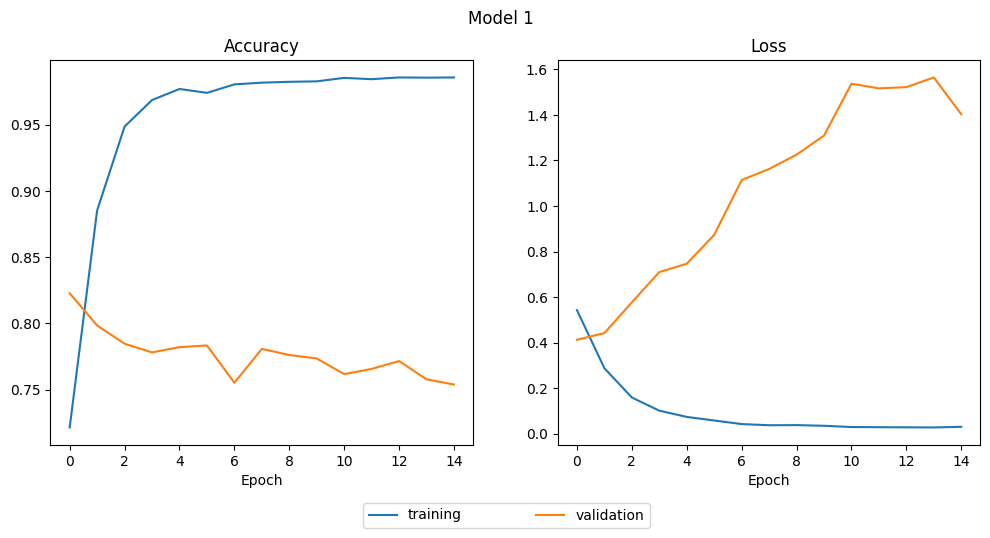

In [36]:
plot_results(history, 1)

We see the that accuracy for the training set is constantly increasing whereas the validation is decreasing over the epoch after reaching its maximum accuracy at the first epoch. Similar results are seen in the loss graph. The loss of the training set is decreasing and levels off but the loss of the validation set it constantly on the up trend.

What we can conclude from this is that the model is vastly overfitting on the training set.

To try to make a better model, an idea would be to modify the learning rate of the model to a lower learning rate, a hyper parameter, so it doesn't rush over the minimum loss point on the validation set and overfit. The default learning rate of the Adam Optimizer is 0.001 so we are going to change the learning rate to a tenth of that, LR = 0.00001.

In [37]:
model2 = Sequential()

model2.add(Input(shape = (len(train_token[0]),)))
model2.add(Embedding(len(word2idx) + 1, 64))
model2.add(Bidirectional(LSTM(64, return_sequences=True)))
model2.add(Bidirectional(LSTM(32)))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 64)            1000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 128)          66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,111,489
Trainable params: 1,111,489
No

In [38]:
history2 = model2.fit(x_train, y_train, epochs=15, validation_data=[x_val, y_val])

Epoch 1/15
191/191 [==============================] - 7s 20ms/step - loss: 0.6816 - accuracy: 0.5645 - val_loss: 0.6620 - val_accuracy: 0.5936
Epoch 2/15
191/191 [==============================] - 3s 16ms/step - loss: 0.5561 - accuracy: 0.7023 - val_loss: 0.4348 - val_accuracy: 0.8122
Epoch 3/15
191/191 [==============================] - 3s 14ms/step - loss: 0.3343 - accuracy: 0.8693 - val_loss: 0.4297 - val_accuracy: 0.8175
Epoch 4/15
191/191 [==============================] - 3s 14ms/step - loss: 0.2387 - accuracy: 0.9140 - val_loss: 0.5102 - val_accuracy: 0.8070
Epoch 5/15
191/191 [==============================] - 3s 14ms/step - loss: 0.1739 - accuracy: 0.9429 - val_loss: 0.5120 - val_accuracy: 0.8011
Epoch 6/15
191/191 [==============================] - 3s 15ms/step - loss: 0.1281 - accuracy: 0.9606 - val_loss: 0.6282 - val_accuracy: 0.7768
Epoch 7/15
191/191 [==============================] - 3s 17ms/step - loss: 0.1033 - accuracy: 0.9700 - val_loss: 0.6758 - val_accuracy: 0.7781

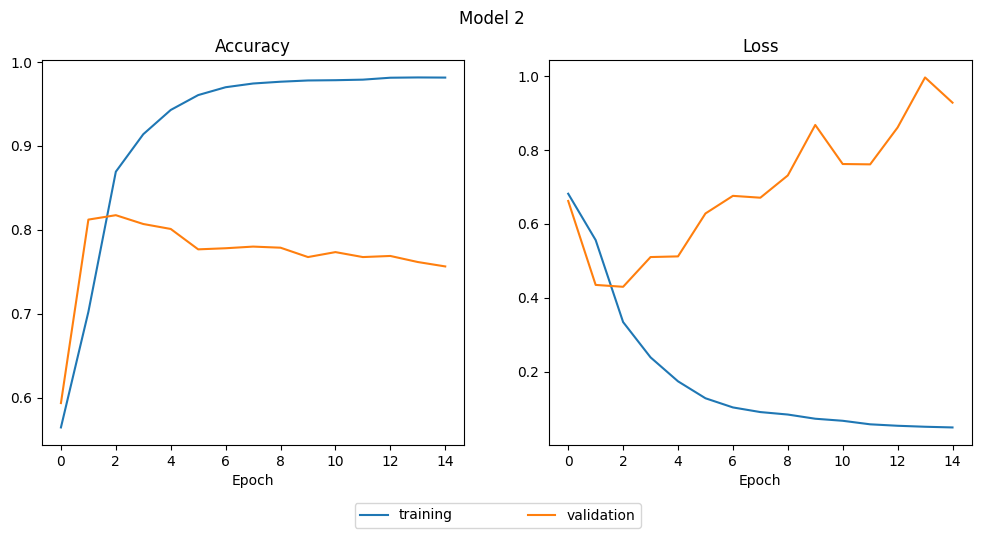

In [39]:
plot_results(history2, 2)

We see that it does slightly better than the previous model. We see there exists a dip, the minimum point in the validation loss plot. But nonetheless, this model, too, is overfitting just like the previous model.

To combat this, I've tried several other combinations of learning rates. But in the end they eventually shoot upwards after a number of epochs or if the learning rate was too low, it wouldn't converge. 

Some ideas could have been to extend the training time with lower learning rates, i.e. epoch > 15 along with a much lower learning rate but I wanted to keep it at 15 epoch to keep it constant and change only the learning rate.

The plan next was to use a dynamic learning rate instead then. That way it can converge faster initially and slow down when there are signs of a plateau - reaching the dip. The following is what I found to work the best.

In [40]:
model3 = Sequential()

model3.add(Input(shape = (len(train_token[0]),)))
model3.add(Embedding(len(word2idx) + 1, 64))
model3.add(Bidirectional(LSTM(64, return_sequences=True)))
model3.add(Bidirectional(LSTM(32)))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer=Adam(0.000013), metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 64)            1000000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 128)          66048     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,111,489
Trainable params: 1,111,489
No

In [41]:
callbacks = [
    #learning schedule
    ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1, min_lr=0.000000001)
]


The callback function here, ReduceLROnPlateau is a tensorflow callback that reduces the learning rate of the optimizer by a factor after a number of epochs showing a plateau (patience). Min_lr is the lower limit of learning rate after all the reduction. I set patience at 1 because from the previous models, it shoots past the minimal point very quickly so I wanted to capture it as fast as I could. Min_lr was chosen arbitrarily since there's very few epochs for the reductions.

In [42]:
history3 = model3.fit(x_train, y_train, epochs=15, validation_data=[x_val, y_val], callbacks=callbacks)

Epoch 1/15
191/191 [==============================] - 7s 20ms/step - loss: 0.6919 - accuracy: 0.5330 - val_loss: 0.6875 - val_accuracy: 0.5936 - lr: 1.3000e-05
Epoch 2/15
191/191 [==============================] - 3s 15ms/step - loss: 0.6871 - accuracy: 0.5645 - val_loss: 0.6807 - val_accuracy: 0.5936 - lr: 1.3000e-05
Epoch 3/15
191/191 [==============================] - 3s 14ms/step - loss: 0.6841 - accuracy: 0.5645 - val_loss: 0.6771 - val_accuracy: 0.5936 - lr: 1.3000e-05
Epoch 4/15
191/191 [==============================] - 3s 14ms/step - loss: 0.6821 - accuracy: 0.5645 - val_loss: 0.6745 - val_accuracy: 0.5936 - lr: 1.3000e-05
Epoch 5/15
191/191 [==============================] - 3s 14ms/step - loss: 0.6802 - accuracy: 0.5645 - val_loss: 0.6720 - val_accuracy: 0.5936 - lr: 1.3000e-05
Epoch 6/15
191/191 [==============================] - 3s 15ms/step - loss: 0.6775 - accuracy: 0.5645 - val_loss: 0.6691 - val_accuracy: 0.5936 - lr: 1.3000e-05
Epoch 7/15
191/191 [====================

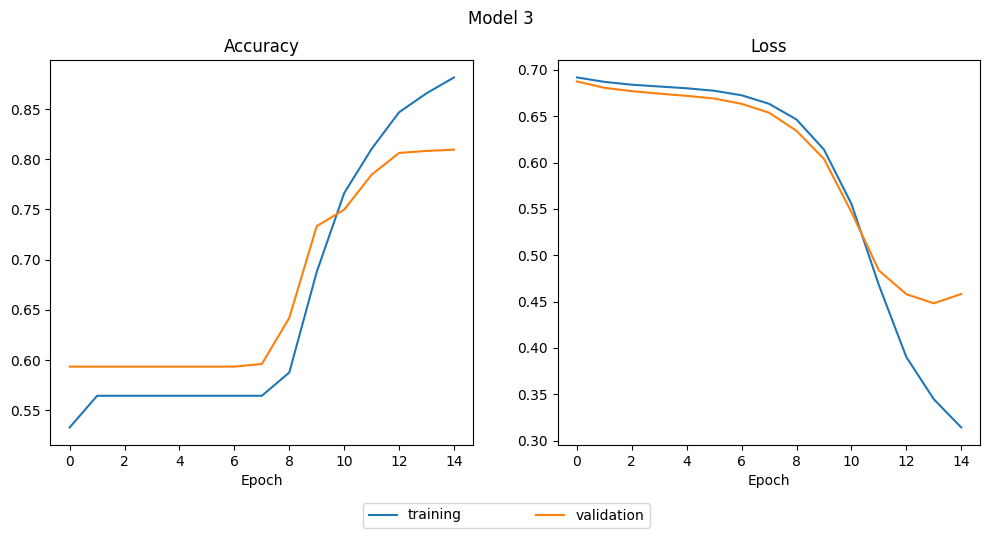

In [43]:
plot_results(history3, 3)

This looks much, much better. We see that the loss is basically reached the convergence point in the loss plot and seems to level off in the accuracy plot in terms of the validation set. It looks like the training set can do more training but after this point the model will probably start to overfit. 

Therefore, in theory, this model should yield the best result out of the two models.

## Results

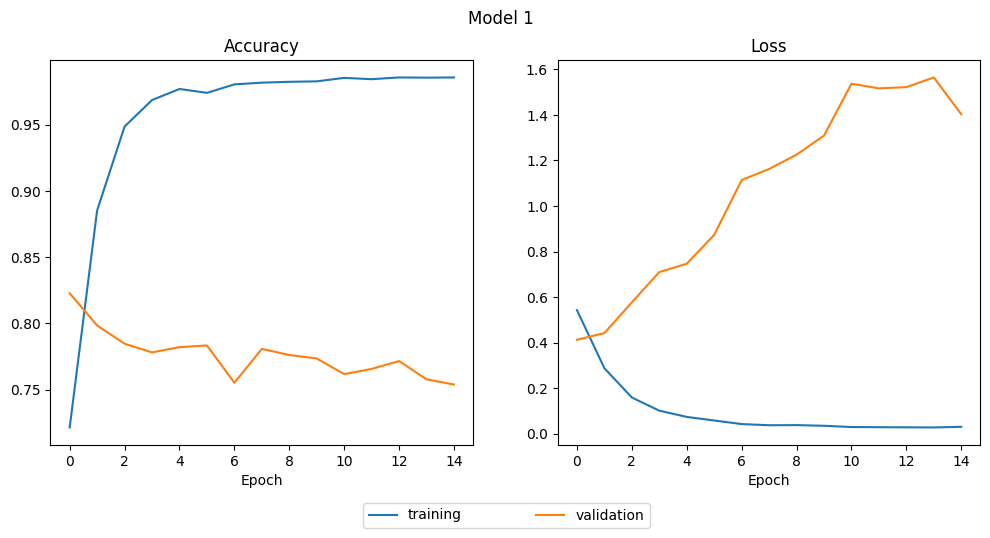

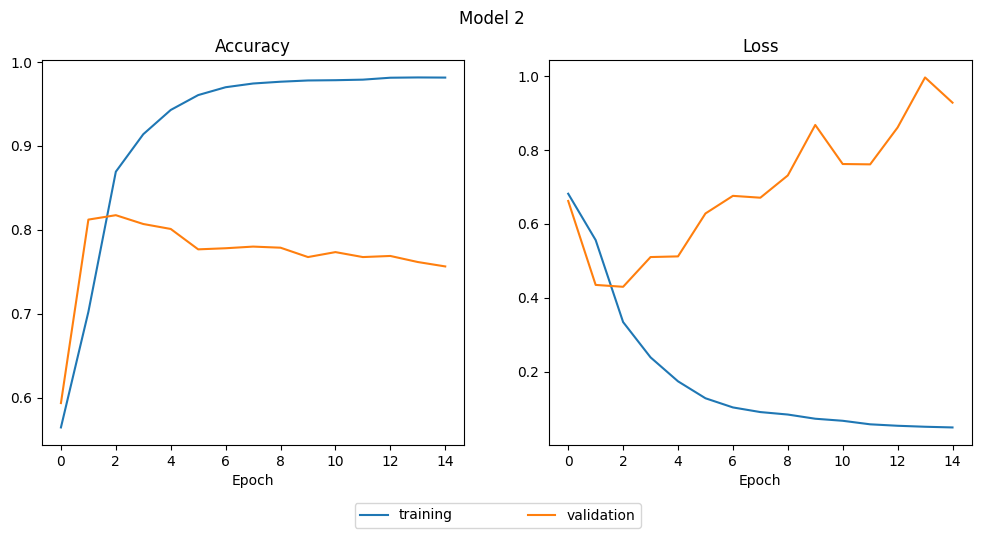

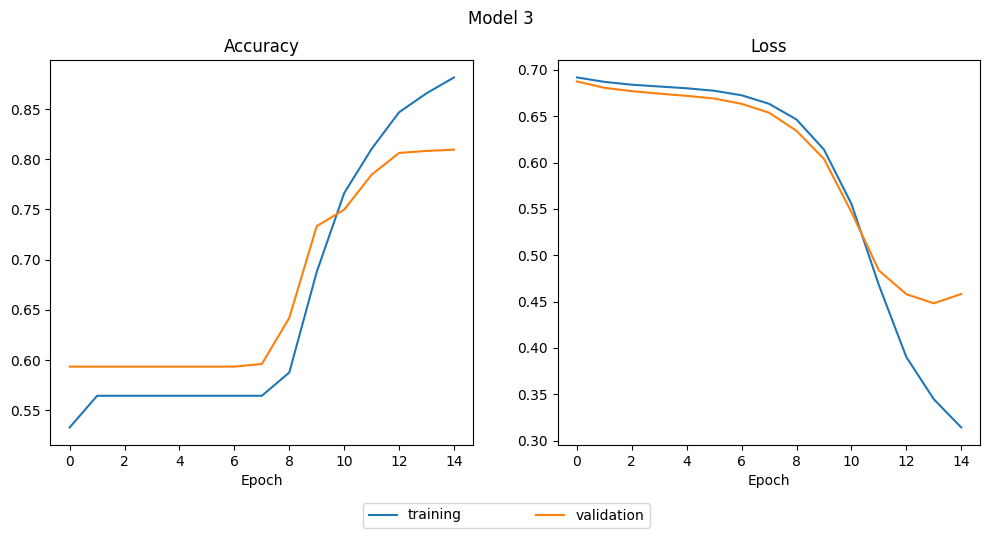

In [44]:
plot_results(history, 1)
plot_results(history2, 2)
plot_results(history3, 3)

Above, we see a summary of the accuracy and loss plots for each model. We notice that the first two models with static learning rates show signs of overfitting and shooting past the minimal loss point in the validation set. The third model with a more dynamic learning rate shows the best result with the validation loss plot reaching essentially its lowest point. This prevents model overfitting and allows generalization to other datasets. Therefore, the model that we are going to use for the submission is model 3.

First we need to prepare the test dataset just like we did earlier with out training set.

In [45]:
# tokenize the test dataset like we did for the training set
test_token = tokenizer.texts_to_sequences(test.text.values)
test_token = pad_sequences(test_token, maxlen=50, padding='post')
test_token

array([[ 174,  822,    6, ...,    0,    0,    0],
       [ 430,  770,  199, ...,    0,    0,    0],
       [ 137,   37,    6, ...,    0,    0,    0],
       ...,
       [ 880,  567,  326, ...,    0,    0,    0],
       [5692, 3329,  387, ...,    0,    0,    0],
       [5411,  821, 2633, ...,    0,    0,    0]])

In [46]:
predictions = model3.predict(test_token)
predictions

102/102 [==============================] - 2s 9ms/step


array([[0.8991048 ],
       [0.22967613],
       [0.89199525],
       ...,
       [0.746072  ],
       [0.9287733 ],
       [0.1682975 ]], dtype=float32)

In [47]:
# reshaping array
predictions = predictions.reshape(1, -1)[0]
predictions = list(map(lambda x: 1 if x >= 0.5 else 0, predictions))

In [48]:
print(len(predictions))

3263


In [49]:
submission = {'id': test.id.values,
             'target': predictions}
submission_df = pd.DataFrame(submission)
submission_df

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [50]:
submission_df.to_csv('submission.csv', index=False)

The resulting submission had a score of 77% accuracy. This is similar to the accuracy shown in the validation accuracy! This shows that the model was generalizable.

## Discussion

To summarize the findings, we find that using a static learning rate may cause training to overshoot the minimal point, be it the local minimum or global minimum. Although we don't know for certain whether its the former or latter because we did not train for a longer time. On the topic of epoch, it's important to consider the training time. For example, if we want to prevent overshooting the minimal point, we can train at much lower learning rates but that would require a much longer training time, more epochs. It wasn't shown in the notebook but in the process of choosing an optimal learning rate, going between 0.0000001 to 0.00001, with the lower LR, the training ended when it just started to take the dive in the loss plot. For such cases, sometimes it's helpful to use a learning rate scheduler where it decreases learning rate following a function (ex. exponential decrease) or using a dynamic learning rate. We used the latter in this notebook and barely found a minimal point.

Although it would have been nice to have a better accuracy score in the submission, it can be due to how we process vectorized the training data. In our preprocessing we tokenized and vectorized the words one by one, in other words, they were unigrams. Perhaps the model could have performed better if it was trained on bigrams, combination of words instead. The reasoning for this conjecture is based on the keywords column. Although we didn't use it, we see that some word combinations are significant in determining whether a tweet is labeled disaster or not.  For example 'suicide bombing', although the words may not be next to each other as seen in the 'body bag' example, the two words 'suicide' and 'bombing' appearing in a tweet may be a significant combination that may be missed from using just unigrams.

Perhaps for a future notebook we can explore this combination. We can even try extend training time at much lower learning rates and see how that compares. 

## Conclusion

Overall, we see that learning rate is an important hyperparameter in neural network training and it's often difficult to find the sweet spot. Using a dynamic learning rate yielded the best model out of the three we tested. We also learn the importance of not relying solely on the results of the training set but also refer to the validation set to prevent overfitting of our model.

## Resources

- https://www.tensorflow.org/text/tutorials/text_classification_rnn
- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
- https://www.kaggle.com/code/noir3747/classification-using-lstm